<a href="https://www.kaggle.com/code/carlosmatherson/cactus-identification-resnet-transfer-learning?scriptVersionId=235779009" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Cactus Identification | ResNet Transfer Learning 🌵

University of Colorado Boulder

DTSA 5511 Final Project

![header.png](https://www.kaggle.com/competitions/13435/images/header)
https://www.kaggle.com/competitions/aerial-cactus-identification

## 1. Introduction

The Mexican VIGIA project aims to build autonomous surveillance systems that include vegetation recognition systems for protected natural areas. Their mission is motivated by the fact that human activity and agriculture are affecting natural areas despite government efforts to surveil and protect Mexico's rich biodiversity. This project addresses identifying columnar cacti from aerial photographs.


For this challenge, I am using the provided dataset of 32x32px aerial images that are labeled to indicate whether it contains a columnar cactus. The objective of this notebook is to create a robust binary classifier capable of accurately identifying these cacti in unseen images. The model's performance is evaluated using the AUC between predicted probabilities and actual labels.

In order to build a high-performing model, I am implementing a transfer learning approach using the ResNet-50 CNN, which is known to demonstrate great performance in image classification tasks. By leveraging the pre-trained weights, I aim to achieve a highly accurate yet highly generalizing binary image classifier while addressing the dataset's class imbalance.


## 2. Environment Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from zipfile import ZipFile
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

2025-04-24 04:37:01.475770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745469421.863942      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745469421.982147      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In the code block below, I attempt to connect to TPU, then fallback to GPU or CPU depending on what is available. For GPU usage with more than 1 replica, mirrored strategy is configured.

In [2]:
def setup_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        device = 'TPU'
    except:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                if not tf.executing_eagerly():
                    tf.config.experimental.set_memory_growth(gpu, True)
            strategy = tf.distribute.MirroredStrategy() if len(gpus) > 1 else tf.distribute.get_strategy()
            device = f'{len(gpus)} GPU(s)'
        else:
            strategy = tf.distribute.get_strategy()
            device = 'CPU'
    print(f'Using {device} with {strategy.num_replicas_in_sync} replicas')
    return strategy

strategy = setup_strategy()

Using 2 GPU(s) with 2 replicas


I0000 00:00:1745469443.267103      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745469443.267870      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## 3. Data Loading and EDA

Unzip images from project data:

In [3]:
with ZipFile('/kaggle/input/aerial-cactus-identification/train.zip') as zipper:
    zipper.extractall()
    
with ZipFile('/kaggle/input/aerial-cactus-identification/test.zip') as zipper:
    zipper.extractall()

Read in the train data with labels and the sample submission file. The sample submission file will be used to generate our final predictions later.

In [4]:
labels = pd.read_csv('/kaggle/input/aerial-cactus-identification/train.csv')
submission = pd.read_csv('/kaggle/input/aerial-cactus-identification/sample_submission.csv')
test_dir_df = pd.DataFrame({'id': os.listdir('/kaggle/working/test')})
train_dir_df = pd.DataFrame({'id': os.listdir('/kaggle/working/train')})

Looking at the first 5 rows of the data, we can see two columns. The first is the JPEG image filename, and the second denotes whether the image contains a cactus. Images that contain a cactus have label 1 and images without any cacti are labeled 0.

In [5]:
labels.sort_values('id').head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


The sample submission files shows us that the submission should have the same columns, retaining the image filename and store the prediction probabilities of having a cactus as determined by the model in the second columns.

In [6]:
train_dir_df.sort_values('id').head()

,id
5771,0004be2cfeaba1c0361d39e2b000257b.jpg
15576,000c8a36845c0208e833c79c1bffedd1.jpg
2294,000d1e9a533f62e55c289303b072733d.jpg
15564,0011485b40695e9138e92d0b3fb55128.jpg
7739,0014d7a11e90b62848904c1418fc8cf2.jpg


In [7]:
submission.sort_values('id').head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [8]:
test_dir_df.sort_values('id').head()

,id
708,000940378805c44108d287872b2f04ce.jpg
4,0017242f54ececa4512b4d7937d1e21e.jpg
3793,001ee6d8564003107853118ab87df407.jpg
2294,002e175c3c1e060769475f52182583d0.jpg
3353,0036e44a7e8f7218e9bc7bf8137e4943.jpg


Need to verify that the images in the submission file are the same in the test folder.

In [9]:
ee = set(test_dir_df['id']) == set(submission['id'])
le = len(test_dir_df) == len(submission)
print(f'elements are the same: {ee}')
print(f'lengths are equal: {le}')

elements are the same: True
lengths are equal: True


A high level look at the data reveals that we have 17500 images to train on and 4000 images to predict on. We can also see that of the 17500 training images, 75% are positive for cacti and 25% do not contain a single columnar cactus. This class imbalance is something that I take into consideration when training the model. During early iterations of this notebook, I noticed that the model was eager to predict images to be members of the majority class because that was sufficient to maximize accuracy but limited the amount the AUC can improve as it was not able to properly discriminate between classes. This final implementation accounts for AUC and accuracy in the training while adequately addressing the class imbalance by implementing class weights.

In [10]:
num_train = len(train_dir_df)
num_test = len(test_dir_df)

print(f'number of train images: {num_train}')
print(f'number of test images: {num_test}')

cactus_count = labels['has_cactus'].sum()
no_cactus_count = len(labels) - cactus_count

print(f"number with cactus: {cactus_count} ({cactus_count/len(labels)})")
print(f"number without cactus: {no_cactus_count} ({no_cactus_count/len(labels)})")

sample_img = cv2.imread('/kaggle/working/train/' + labels['id'].iloc[9])
print(f"image shape: {sample_img.shape}")

number of train images: 17500
number of test images: 4000
number with cactus: 13136 (0.7506285714285714)
number without cactus: 4364 (0.24937142857142858)
image shape: (32, 32, 3)


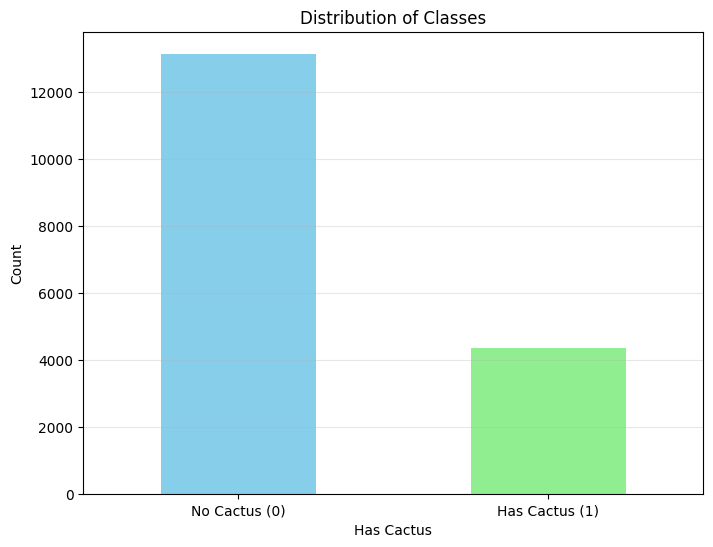

In [11]:
plt.figure(figsize=(8, 6))
labels['has_cactus'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Distribution of Classes')
plt.xlabel('Has Cactus')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Cactus (0)', 'Has Cactus (1)'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [12]:
def display_aerial_images(labels=None, n_images=12, has_cactus=True):
    n_rows = int(np.floor(np.sqrt(n_images)))
    n_cols = int(np.ceil(n_images/n_rows))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
    axes = axes.flatten()  

    if has_cactus:
        images = labels[labels['has_cactus'] == 1]['id'][-n_images:]
    else:
        images = labels[labels['has_cactus'] == 0]['id'][-n_images:]

    for idx, img_name in enumerate(images):
        img_path = 'train/' + img_name                 
        image = cv2.imread(img_path)                   
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        
        axes[idx].imshow(image)
        axes[idx].axis('off') 
        
        for i in range(len(images), len(axes)):
            axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

Below we can see sets of images of class 1 that contain columnar cacti. The cacti are visible in the images despite their low resolution. We can see the tubular shapes of cacti.

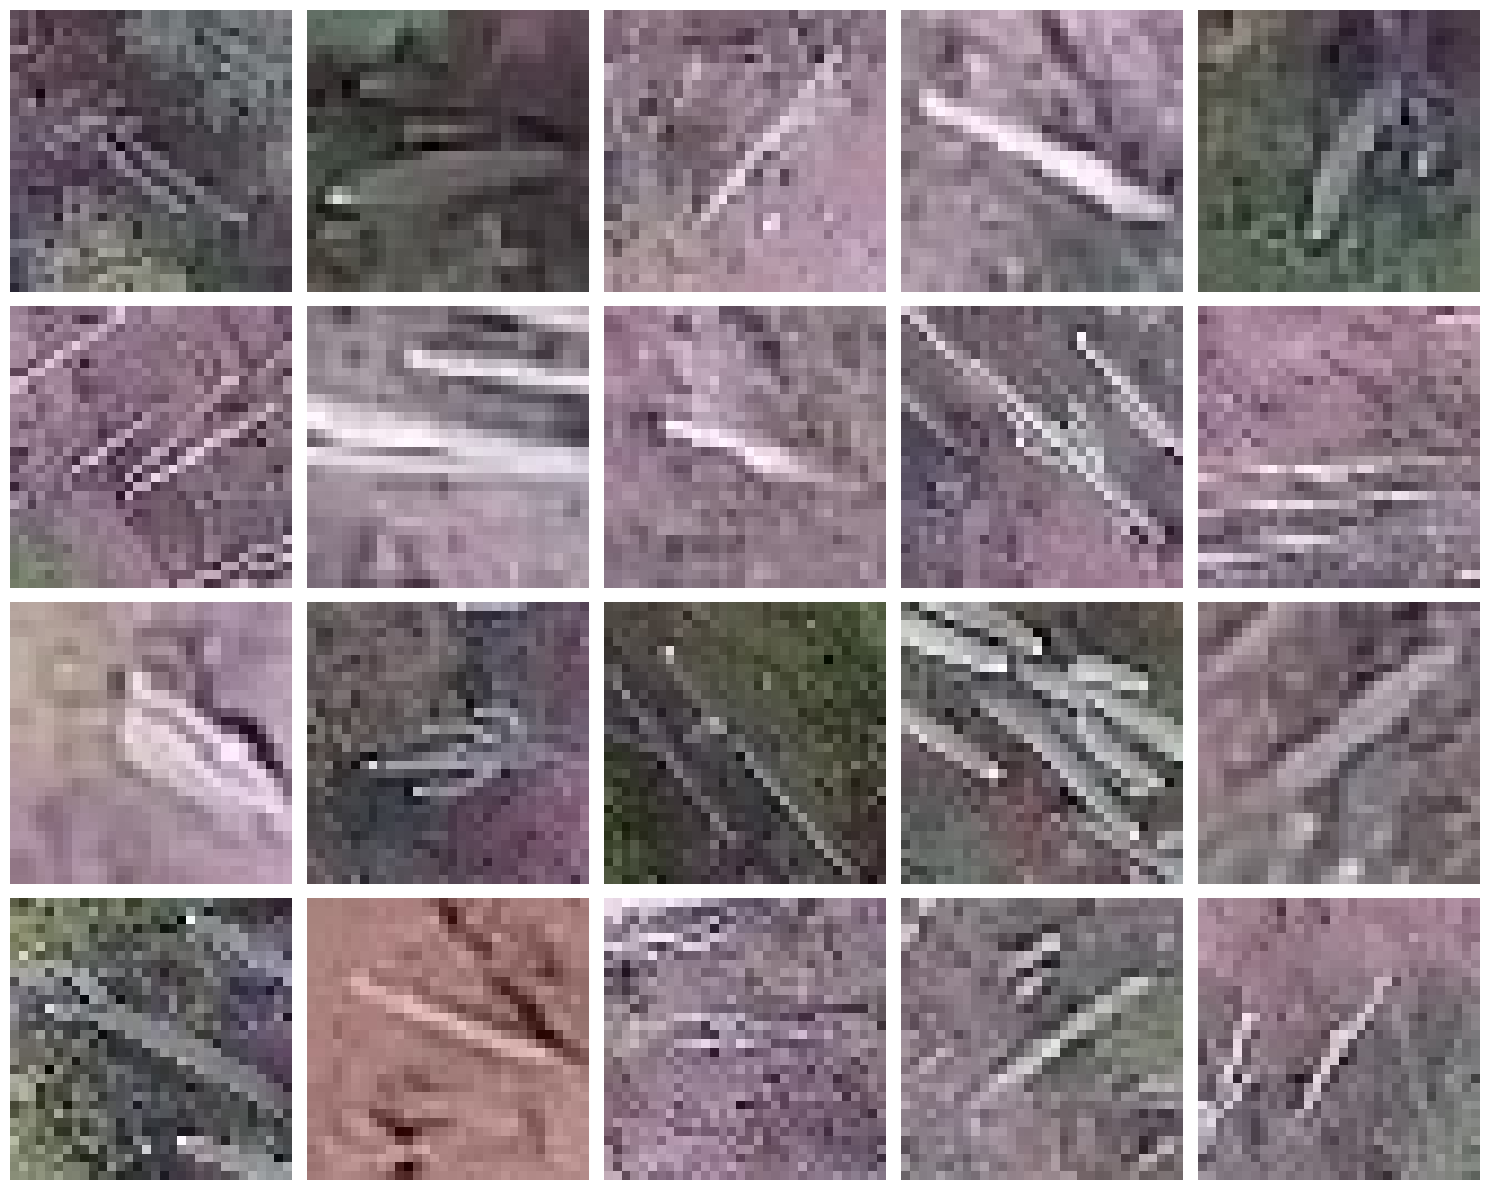

In [13]:
display_aerial_images(labels=labels, n_images=20, has_cactus=True)

In the images below we see class 0 not containing cacti. In some of the images there are structures that look like they may be cacti, which are features the model will need to learn to discriminate between.

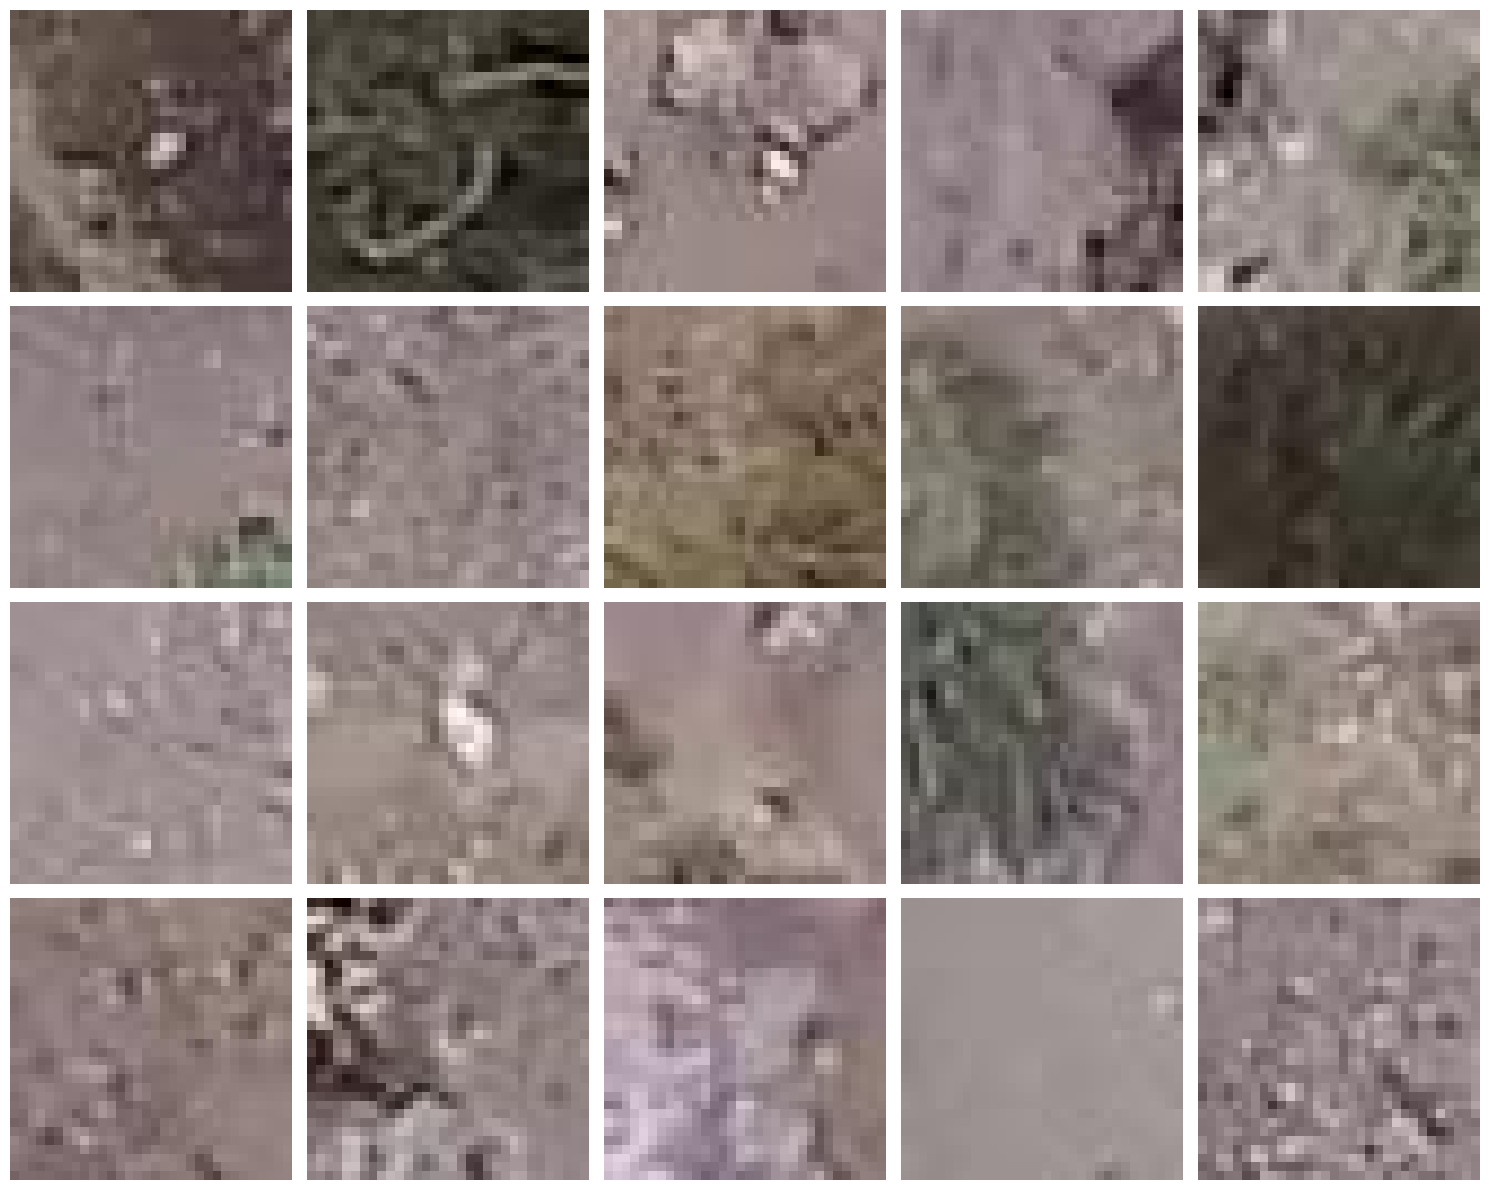

In [14]:
display_aerial_images(labels=labels, n_images=20, has_cactus=False)

## 4. Data Preprocessing

Before training the model, the data needs to be split into training and validation sets. Using sklearn, I implement an 80/20 train-validation split resulting in 14000 training images and 3500 validation images.

In [15]:
# Create train and validation splits
train_df, val_df = train_test_split(labels, 
                                    test_size=0.2, 
                                    stratify=labels['has_cactus'], 
                                    random_state=19)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")

Training set: 14000 images
Validation set: 3500 images


Training the model on the images in their raw form can cause overfitting and inability to generalize as the model is more likely to simply memorize each picture that is sees. To ensure that the model is picking up on the underlying patterns to identify columnar cacti while minimizing overfitting, the data is augmented using ResNet's native image preprocessor in addition to transforming the images with rotations, shifts, zoom, and flips. 

In addition to maximizing generalization, these augmentations have physical applications. Rotations simulate different drone orientations, shifts and zooms account for drone position and camera zoom, and flips provide an analog to various orientations and patterns of objects in the nature that is being photographed. In terms of real-world application, these augmentations allow the model to recognize cacti regardless of their orientation, size, or position in the field of view.

ResNet's preprocessor function performs several critical operations to prepare images in the format the model expects. It converts images from RGB to BGR color channel ordering, performs channel-wise mean subtraction using ImageNet's mean values, but does not rescale values. This ensures new images match the distribution the pre-trained model expects, which is important for transfer learning.

At this point, the images are also upscaled from 32x32 to 224x224 to match ResNet's input dimensions, as the architecture was designed and pre-trained on 224x224 pixel images. To account for data loss from scaling the images up in size, the gaps are filled using the nearest pixel interpolation method.

Data generators are created for each step in the process (training, validation, testing) to avoid data leakage and keep predictions aligned with the order of the images in the data set.

In [16]:
IMG_SIZE = 224
batch_size = 128

# used for training
datagen_augmentation = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# used for val and test
datagen_val_rescale = ImageDataGenerator(preprocessing_function=preprocess_input)
datagen_test_rescale = ImageDataGenerator(preprocessing_function=preprocess_input)

In [17]:
# convert has_cactus to string for compatibility with flow_from_dataframe
train_df['has_cactus'] = train_df['has_cactus'].astype(str)
val_df['has_cactus'] = val_df['has_cactus'].astype(str)

In [18]:
train_generator = datagen_augmentation.flow_from_dataframe(
    dataframe=train_df,
    directory='/kaggle/working/train',
    x_col='id',
    y_col='has_cactus',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = datagen_val_rescale.flow_from_dataframe(
    dataframe=val_df,
    directory='/kaggle/working/train',
    x_col='id',
    y_col='has_cactus',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = datagen_test_rescale.flow_from_dataframe(
    dataframe=submission,
    directory='/kaggle/working/test',
    x_col='id',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 14000 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames.


In [19]:
def plot_augmented_images(generator, title):

    x_batch, y_batch = next(generator)
    
    plt.figure(figsize=(16, 8))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"Class: {int(y_batch[i])}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

Below are example of the augmented images. ResNet's preprocessor function prepares images in the format that it expects. These operations include BGR color channel ordering and zero-centering (channel-wise mean subtraction) using the values from the ImageNet data.

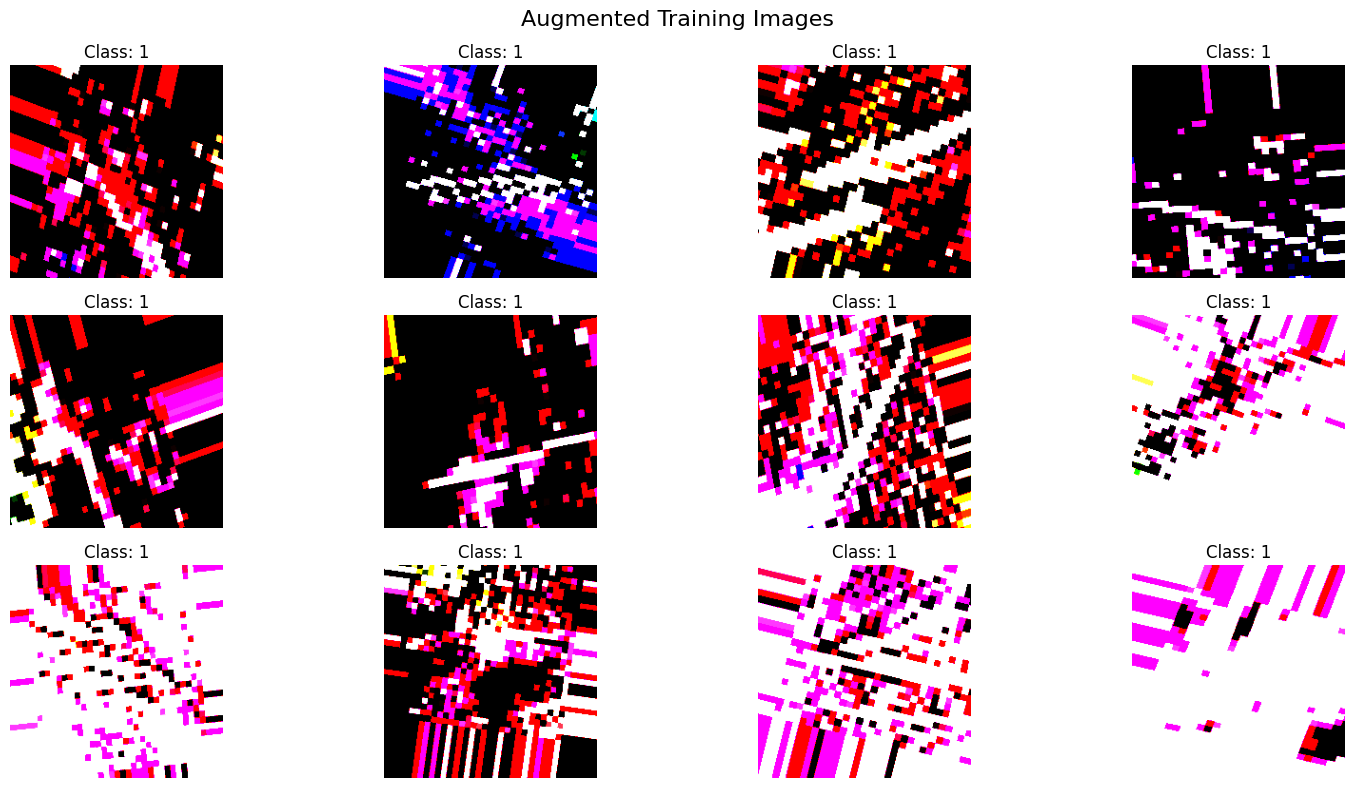

In [20]:
plot_augmented_images(train_generator, 'Augmented Training Images')

## 5. Model Implementation

The model architecture utilizes ResNet-50's 50-layer deep residual network pretrained on ImageNet, a large image database with more than 14 million images designed for use in computer vision, as a feature extractor with selective fine tuning of deeper layers. ResNet-50 effectively learns hierarchical features while avoiding the vanishing gradient problem through skip connections and has shown to be suitable for distinguishing objects. 

The model was instantiated with the last 10 layers of the CNN set to be trainable while earlier layers remain frozen with their original weights. This approach leverages transfer learning principles by keeping the early layers of ResNet-50 frozen to retain their general-purpose feature extraction capabilities (edges, textures, shapes) learned from ImageNet. By making only the last 10 layers trainable, I allow the model to adapt its higher-level, more abstract representations to the specific characteristics of columnar cacti while maintaining the robust low-level feature detection. This strategy is computationally efficient and prevents overfitting on our relatively small domain-specific dataset.

On top of the base ResNet architecture, I've added custom layers specific for this classification task. After the last convolutional layer of ResNet-50, I added a global average pooling layer to convert the 3D feature map into a 1D summary representation. Then, I added a fully connected layer that uses the relu activation function to extract the features from the pooled vector and to mitigate the vanishing gradient problem. After that, I added a 30% dropout layer to prevent overfitting. The last layer is a single neuron sigmoid activation function that does the classification by outputting the likelihood that a cactus is in the image.

![1*VM94wVftxP7wkiKo4BjfLA.webp](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*VM94wVftxP7wkiKo4BjfLA.png)
https://medium.com/@nitishkundu1993/exploring-resnet50-an-in-depth-look-at-the-model-architecture-and-code-implementation-d8d8fa67e46f

In [21]:
def build_model(freeze=True, n_trainable=10):

    input_shape = (IMG_SIZE, IMG_SIZE, 3)

    input_layer = Input(shape=input_shape)
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    # Freeze base model layers
    if freeze:
        for layer in base_model.layers:
            layer.trainable = False
    else:    
        for layer in base_model.layers[-n_trainable:]:
            layer.trainable = True
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')],
    )
    
    return model

In [22]:
model = build_model(freeze=False, n_trainable=10)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 24,584,193 (93.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 6. Model Training

Training was conducted using a learning rate of 0.0001, the binary cross-entropy loss function, a batch size of 128 to take advantage of the NVIDIA Tesla T4s made available through kaggle, class weights to address imbalance, and multiple callbacks to stop training on convergence, adjust the learning rate when it plateaus, and save the best model after each epoch with improved validation AUC.

To address the 75%/25% class imbalance, I calculate the class weights to be inversely proportional to their frequencies, giving the minority class (no cactus) 3 times the weight of the majority class (has cactus) during the loss calculation. During training, these weights modify the loss function to penalize misclassifications of the underrepresented class more heavily. This way the model does not achieve high accuracy by simply predicting the majority class for every image.

In [23]:
train_labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 2.005156115726153, 1: 0.6660957274716909}


In [24]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_auc',
        mode='max',
        verbose=1
    )
]

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

Steps per epoch: 110
Validation steps: 28
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745469516.169883      62 service.cc:148] XLA service 0x7e579c0020c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745469516.171617      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745469516.171638      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745469520.857403      62 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745469563.801050      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9315 - auc: 0.9801 - loss: 0.1353
Epoch 1: val_auc improved from -inf to 0.99613, saving model to best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.9318 - auc: 0.9803 - loss: 0.1346 - val_accuracy: 0.9783 - val_auc: 0.9961 - val_loss: 0.0984 - learning_rate: 1.0000e-04
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9940 - auc: 0.9995 - loss: 0.0180
Epoch 2: val_auc improved from 0.99613 to 0.99859, saving model to best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9940 - auc: 0.9995 - loss: 0.0180 - val_accuracy: 0.9931 - val_auc: 0.9986 - val_loss: 0.0264 - learning_rate: 1.0000e-04
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9909 - auc: 0.9996 - loss: 0.0215
Epoch 3: val_auc improved from 0.99859 to 0.99919, saving model to best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9909 - auc: 0.9996 - loss: 0.0215 - val_accuracy: 0.9

In [25]:
best_model = tf.keras.models.load_model('best_model.keras')

## 7. Model Evaluation

Below are charts of the training history. The figures show a generally consistent improvement in all metrics with some disruption that quickly recovers. Accuracy, loss, and AUC all demonstrate outstanding model performance.

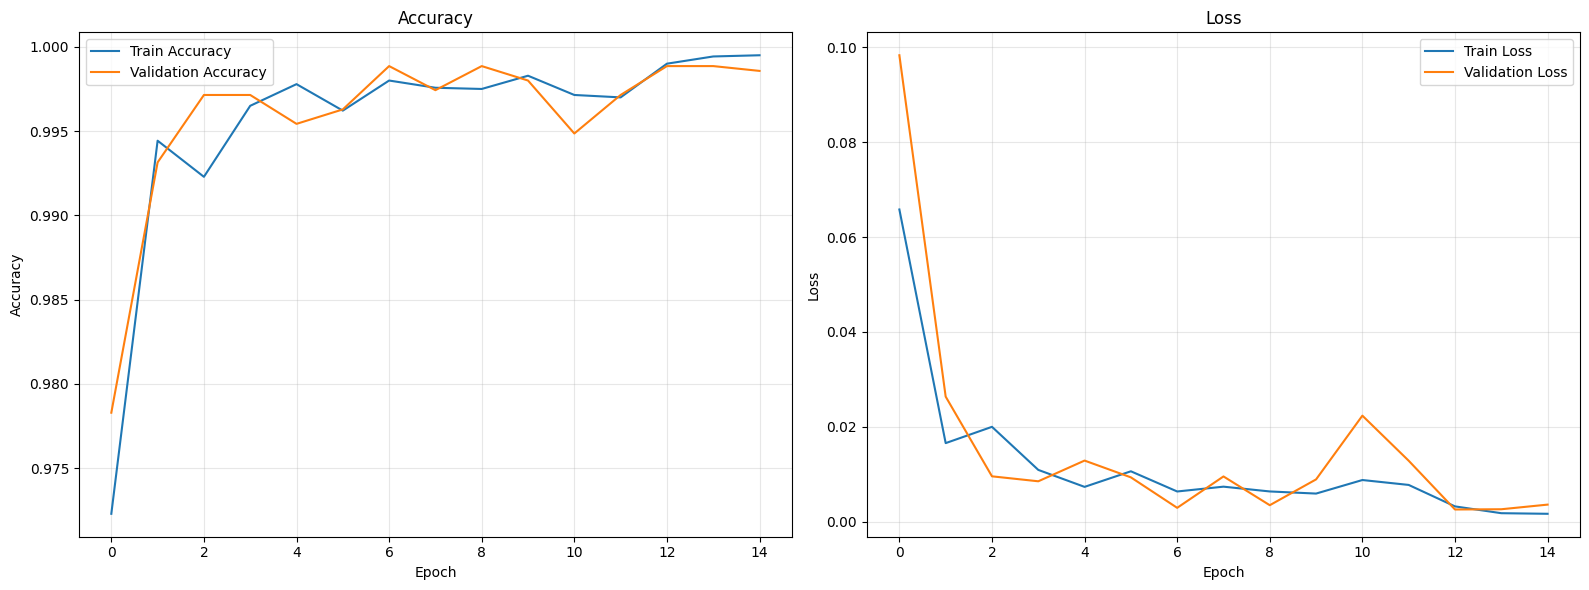

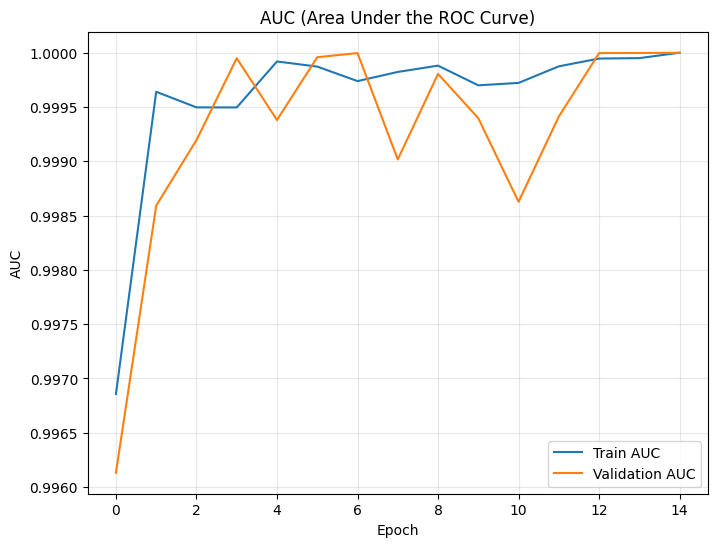

In [26]:
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(16, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot AUC
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC (Area Under the ROC Curve)')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_training_history(history)

28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 438ms/step


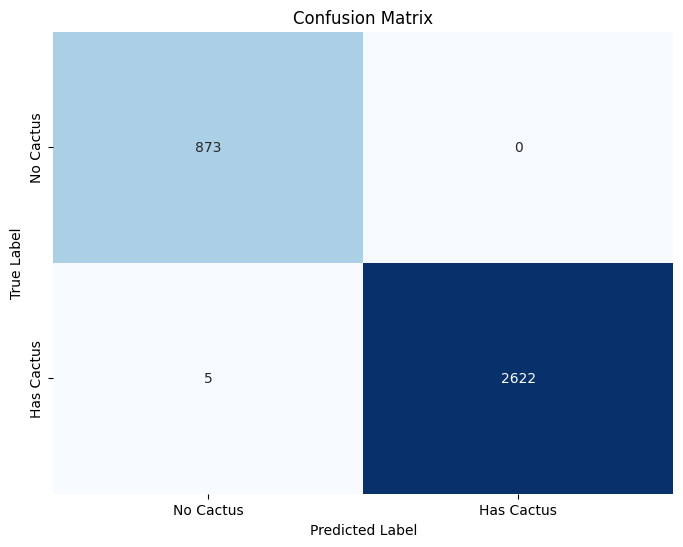

Classification Report:
              precision    recall  f1-score   support

   No Cactus       0.99      1.00      1.00       873
  Has Cactus       1.00      1.00      1.00      2627

    accuracy                           1.00      3500
   macro avg       1.00      1.00      1.00      3500
weighted avg       1.00      1.00      1.00      3500



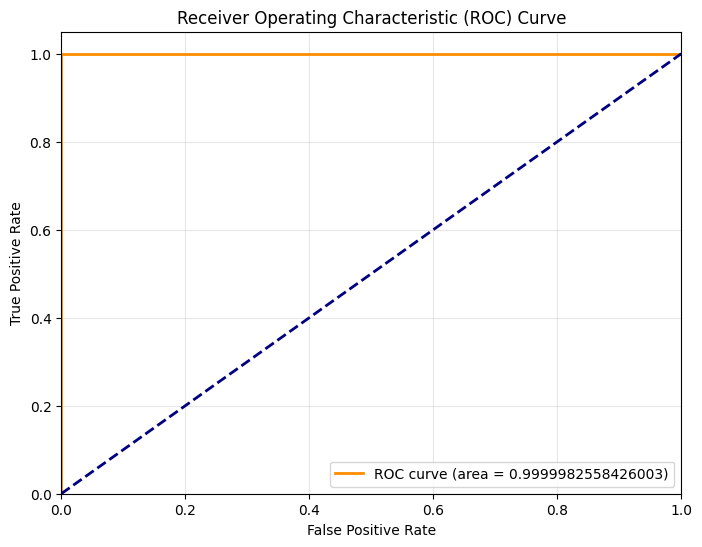

In [27]:
# get predictions on validation set
val_generator.reset()
Y_pred = model.predict(val_generator, steps=len(val_generator))
Y_pred_classes = (Y_pred > 0.5).astype(int)
Y_true = val_generator.classes

# confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Cactus', 'Has Cactus'],
            yticklabels=['No Cactus', 'Has Cactus'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# classification report
print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=['No Cactus', 'Has Cactus']))

# ROC curve
fpr, tpr, _ = roc_curve(Y_true, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

The confusion matrix reveals excellent classification with limited misclassification of the 3500 validation images. The classification report above confirms the near-perfect performance with precision, recall, and F1-scores all close to 1. 

The ROC curve demonstrates perfect discrimination ability with an AUC of 1. Looking into the model's ability to separate positive and negative classes further, we can see that the prediction distribution shows highly confident predictions as most values are clustered near 0 or 1. The model shows strong decisiveness when classifying images into two classes.

Y_pred shape: (3500, 1)
Y_true shape: (3500,)
Y_pred range: 4.0168924e-34 1.0


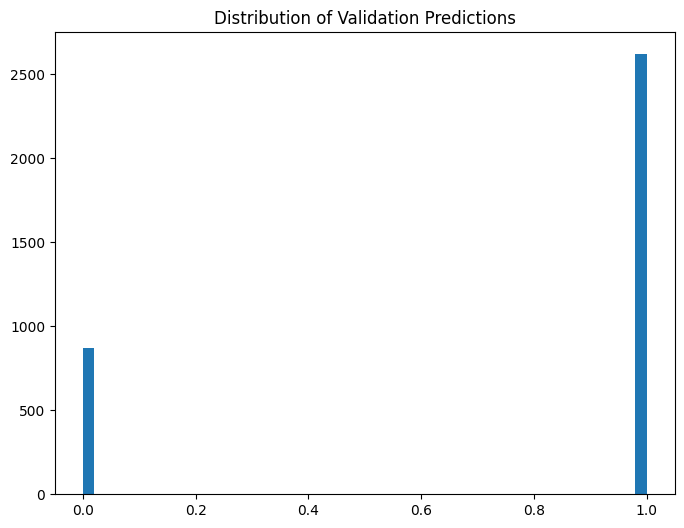

Class distribution in validation set:
[ 873 2627]
ROC AUC: 0.9999982558426003


In [28]:
Y_true = np.array(Y_true)
print("Y_pred shape:", Y_pred.shape)
print("Y_true shape:", Y_true.shape)
print("Y_pred range:", np.min(Y_pred), np.max(Y_pred))

# check distribution of predictions
plt.figure(figsize=(8, 6))
plt.hist(Y_pred, bins=50)
plt.title('Distribution of Validation Predictions')
plt.show()

# checkch class balance in true labels
print("Class distribution in validation set:")
print(np.bincount(Y_true))

# ROC calculation
fpr, tpr, _ = roc_curve(Y_true, Y_pred)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")

## 8. Generate Predictions

In this section, I simply generate the predictions for each test image and place them in the appropriate column of the sample submission file, replacing the sample data, and save the result as a new file.

In [29]:
# predict on test data
test_generator.reset()
test_predictions = model.predict(test_generator, steps=len(test_generator))

# Create submission dataframe
submission['has_cactus'] = test_predictions
submission.head()

# save file
submission.to_csv('submission.csv', index=False)
print("Submission saved successfully!")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step
Submission saved successfully!


Below are examples of predictions made by the model. Images with red borders indicate that the model predicts there to be a cactus in the photo (blue otherwise).

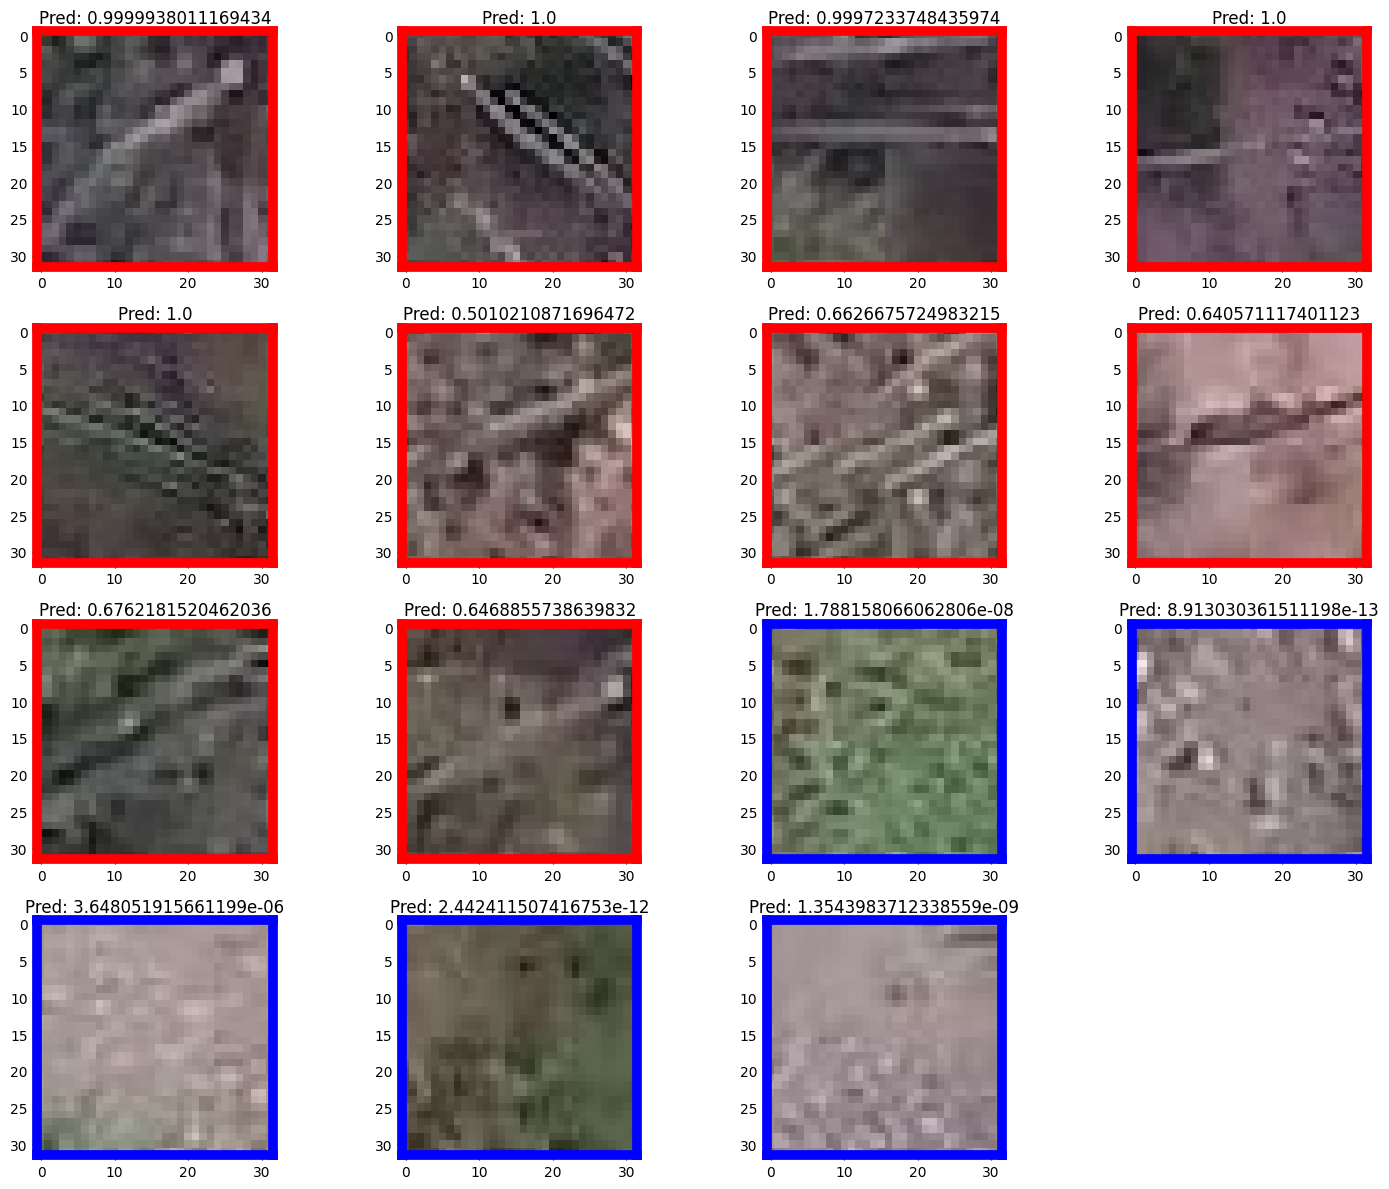

In [30]:
def display_test_predictions(submission_df, n_images=12, threshold=0.5):
    n_rows = int(np.floor(np.sqrt(n_images)))
    n_cols = int(np.ceil(n_images/n_rows))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
    axes = axes.flatten()
    
    # Get a mix of predictions
    high_conf_cactus = submission_df[submission_df['has_cactus'] > 0.9]['id'].iloc[:n_images//3]
    low_conf_cactus = submission_df[(submission_df['has_cactus'] > threshold) & 
                                    (submission_df['has_cactus'] < 0.7)]['id'].iloc[:n_images//3]
    high_conf_no_cactus = submission_df[submission_df['has_cactus'] < 0.1]['id'].iloc[:n_images//3]
    
    images = pd.concat([high_conf_cactus, low_conf_cactus, high_conf_no_cactus])
    
    for idx, img_name in enumerate(images):
        if idx >= n_images:
            break
            
        img_path = 'test/' + img_name
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        pred = submission_df.loc[submission_df['id'] == img_name, 'has_cactus'].values[0]
        
        axes[idx].imshow(image)
        axes[idx].set_title(f"Pred: {pred}")
        
        # Red border for predicted cactus, blue for no cactus
        border_color = 'red' if pred > threshold else 'blue'
        for spine in axes[idx].spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(7)
            spine.set_visible(True)
    
    for i in range(len(images), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

display_test_predictions(submission, n_images=16)

Y_pred shape: (4000, 1)


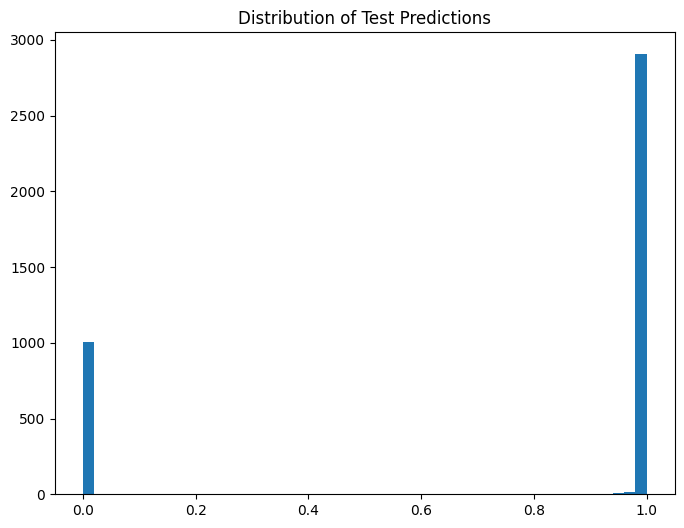

In [31]:
Y_pred_classes = (Y_pred > 0.5).astype(int)
print("Y_pred shape:", test_predictions.shape)

# check distribution of test predictions
plt.figure(figsize=(8, 6))
plt.hist(test_predictions, bins=50)
plt.title('Distribution of Test Predictions')
plt.show()

## 9. Conclusion

This project successfully developed a high-performing deep learning model for identifying columnar cacti in aerial imagery, achieving near-perfect classification with an AUC of 1. The transfer learning approach using ResNet-50 with selective layer training proved highly effective, allowing the model to leverage pre-trained weights while adapting to the specific task at hand.

The success exhibited by the model can be attributed to key decisions made in its development such as unfreezing last 10 layers to be trainable, handling the class imbalance through weighted loss values, and data augmentation.

The developed model demonstrates the potential of deep learning for environmental monitoring applications. It could serve as a crucial component in the VIGIA project's efforts in developing an autonomous surveillance system for protecting natural areas.

While achieving near-perfect classification metrics is impressive, I am appropriately skeptical of the results. This kind of performance typically comes with concerns. One of which is that the test set might be too similar to the training data, causing the model to have basically memorized the test data during training. Another concern is that the features distinguishing cacti in these images might be unusually clear compared to real-world conditions, but I do not think this is the case since the images are blurry and have been upscaled resulting in loss of information. Something that is more likely is that there may be patterns specific to the dataset provided that the model exploits. Exposure to different images outside of the current dataset may reveal that this is the case. 

In future iterations of the model, I would like to fine tune it further and expose it to more diverse imagery to ensure that the model generalizes well. This includes testing on images from different geographic regions, altitudes, lighting conditions, and camera systems. Moreover, expanding this model to identify various species of vegetation is a natural next step in terms of conservation efforts.